In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB=dict()
DATA_URL='http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name,cache_dir=os.path.join('..','data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}"
    url,sha1_hash=DATA_HUB[name]
    os.makedirs(cache_dir,exist_ok=True)
    fname=os.path.join(cache_dir,url.split('/')[-1])
    if os.path.exists(fname):
        sha1=hashlib.sha1()
        with open(fname,'rb') as f:
            while True:
                data=f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest()==sha1_hash:
            return fname    # 命中缓存
    print(f"正在从{url}下载{fname}...")
    r=requests.get(url,stream=True,verify=True)
    with open(fname,'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name,folder=None):
    """下载并解压zip/tar文件"""
    fname=download(name)
    base_dir=os.path.dirname(fname)
    data_dir,ext=os.path.splitext(fname)
    if ext=='.zip':
        fp=zipfile.ZipFile(fname,'r')
    elif ext in ('.tar','.gz'):
        fp=tarfile.open(fname,'r')
    else:
        assert False,'只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir,folder) if folder else data_dir

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (DATA_URL + 'kaggle_house_pred_train.csv','585e9cc93e70b39160e7921475f9bcd7d31219ce')
DATA_HUB['kaggle_house_test'] = (DATA_URL + 'kaggle_house_pred_test.csv','fa19780a7b011d9b009e8bff8e99922a8ee2eb90')
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))

In [3]:
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [4]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [5]:
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape,all_features.dtypes

((2919, 79),
 MSSubClass         int64
 MSZoning          object
 LotFrontage      float64
 LotArea            int64
 Street            object
                   ...   
 MiscVal            int64
 MoSold             int64
 YrSold             int64
 SaleType          object
 SaleCondition     object
 Length: 79, dtype: object)

数据预处理

In [6]:
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features]=all_features[numeric_features].fillna(0) # 在标准化数据之后,所有均值消失,因此我们可以将缺失值设置为0

In [7]:
all_features=pd.get_dummies(all_features,dummy_na=True) # "dummy_na=True"将"na"(缺失值)视为有效的特征值,并为其创建指示符特征
all_features.shape,all_features.dtypes

((2919, 331),
 MSSubClass               float64
 LotFrontage              float64
 LotArea                  float64
 OverallQual              float64
 OverallCond              float64
                           ...   
 SaleCondition_Alloca       uint8
 SaleCondition_Family       uint8
 SaleCondition_Normal       uint8
 SaleCondition_Partial      uint8
 SaleCondition_nan          uint8
 Length: 331, dtype: object)

In [8]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

训练（使用线性模型作为基线模型）

In [9]:
loss=nn.MSELoss()
in_features=train_features.shape[1]

def get_net():
    net=nn.Sequential(nn.Linear(in_features,1))
    return net

def log_rmse(net,features,labels):
    # 为了在取对数时进一步稳定该值,将小于1的值设置为1
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

In [10]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    """训练一个带有损失平方的线性模型作为基线模型"""
    train_ls,test_ls=[],[]  # 储存每个迭代周期后的训练和测试损失
    train_iter=d2l.load_array((train_features,train_labels),batch_size)
    optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay) # Adam优化算法
    for epoch in range(num_epochs):
        for X,y in train_iter:
            optimizer.zero_grad()
            l=loss(net(X),y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [11]:
def get_k_fold_data(k,i,X,y):
    """选择第i个切片作为验证数据,其余作为训练数据"""
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    """K折交叉验证"""
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
        print(f'折{i+1}, 训练log rmse {float(train_ls[-1]):f}, 验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k,valid_l_sum/k

折1, 训练log rmse 0.169809, 验证log rmse 0.156991
折2, 训练log rmse 0.162506, 验证log rmse 0.193687
折3, 训练log rmse 0.163349, 验证log rmse 0.167736
折4, 训练log rmse 0.168370, 验证log rmse 0.154884
折5, 训练log rmse 0.163616, 验证log rmse 0.183199
5-折验证: 平均训练log rmse: 0.165530, 平均验证log rmse: 0.171299


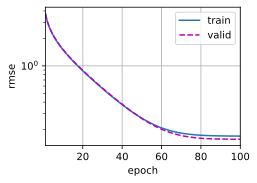

In [12]:
k,num_epochs,lr,weight_decay,batch_size=5,100,5,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

训练（自行改进模型）

First Try  Score: 0.12491  Rank: 558/4053

折1, 训练log rmse 0.080193, 验证log rmse 0.118325
折2, 训练log rmse 0.077498, 验证log rmse 0.140616
折3, 训练log rmse 0.068883, 验证log rmse 0.132437
折4, 训练log rmse 0.073277, 验证log rmse 0.106527
折5, 训练log rmse 0.069528, 验证log rmse 0.144371
5-折验证: 平均训练log rmse: 0.073876, 平均验证log rmse: 0.128455


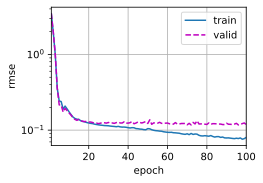

In [49]:
def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.kaiming_normal_(m.weight)

def get_net_mlp():
    net=nn.Sequential(nn.Flatten(),
                      nn.Linear(in_features,1024),
                      nn.ReLU(),
                      nn.Linear(1024,1))
    net.apply(init_weights)
    return net

def k_fold_mlp(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=get_net_mlp()
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.plot(list(range(1,num_epochs+1)),[train_ls,valid_ls],xlabel='epoch',ylabel='rmse',xlim=[1,num_epochs],legend=['train','valid'],yscale='log')
        print(f'折{i+1}, 训练log rmse {float(train_ls[-1]):f}, 验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum/k,valid_l_sum/k

k,num_epochs,lr,weight_decay,batch_size=5,100,0.05,100,128
train_l,valid_l=k_fold_mlp(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, 平均验证log rmse: {float(valid_l):f}')

训练log rmse: 0.069003


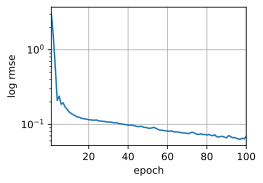

In [51]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    """生成测试结果"""
    net=get_net_mlp()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.plot(np.arange(1,num_epochs+1),[train_ls],xlabel='epoch',ylabel='log rmse',xlim=[1,num_epochs],yscale='log')
    print(f'训练log rmse: {float(train_ls[-1]):f}')
    preds=net(test_features).detach().numpy()                   # 将网络应用于测试集
    test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])    # 将其重新格式化以导出到Kaggle
    submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('../data/kaggle_house_pred_submission.csv',index=False)

train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)